In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from scipy.stats import iqr
import joblib
import warnings





# load data

In [66]:
def load_data(filepath):
    df = pd.read_csv(filepath, usecols=[
        'seed_id', 'temperature', 'soil_temperature', 'soil_moisture',
        'percipitation', 'sunshine_duration', 'humid']
    )
    return df

# Remove outliers

In [69]:
def remove_outliers_iqr(df):
    df_numeric = df.drop(columns=['seed_id'])
    for col in df_numeric.columns:
        Q1 = df_numeric[col].quantile(0.25)
        Q3 = df_numeric[col].quantile(0.75)
        iqr_val = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * iqr_val) & (df[col] <= Q3 + 1.5 * iqr_val)]
    return df


# feature scaling


In [72]:
def scale_features(df):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df.drop(columns=['seed_id']))
    return scaled, scaler

# GMM clustering

In [95]:
def apply_gmm_clustering(data, n_components=5):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(data)
    return labels, gmm


# pca

In [98]:
def visualize_pca(data, labels):
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title('PCA of Clusters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Cluster')
    plt.show()

# algorithm

In [101]:
def train_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    adasyn = ADASYN(random_state=42)
    X_res, y_res = adasyn.fit_resample(X_train, y_train)

    clf1 = XGBClassifier(random_state=42, eval_metric='mlogloss')
    clf2 = RandomForestClassifier(random_state=42)
    clf3 = KNeighborsClassifier()
    
    ensemble = VotingClassifier(estimators=[
        ('xgb', clf1),
        ('rf', clf2),
        ('knn', clf3)
    ], voting='hard')

    ensemble.fit(X_res, y_res)
    y_pred = ensemble.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return ensemble

# predictions

In [133]:
def recommend_seeds(input_values, scaler, model, cluster_labels, df, feature_data, top_n=30):
    input_scaled = scaler.transform(np.array(input_values).reshape(1, -1))
    cluster_pred = model.predict(input_scaled)
    cluster_group = np.where(cluster_labels == cluster_pred[0])[0]
    cluster_features = feature_data[cluster_labels == cluster_pred[0]]
    cluster_df = df.iloc[cluster_group]

    nn = NearestNeighbors(n_neighbors=min(top_n, len(cluster_features)))
    nn.fit(cluster_features)
    _, indices = nn.kneighbors(input_scaled)
    recommended = cluster_df.iloc[indices[0]]['seed_id'].values
    return cluster_pred[0], recommended


# Main Execution Pipeline (Data → Clustering → Model Training → Prediction)

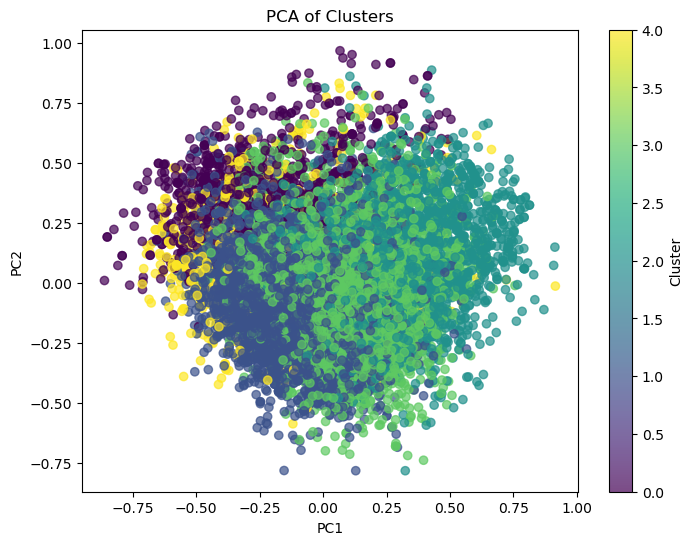


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       323
           1       1.00      0.99      1.00      1716
           2       0.99      1.00      1.00       728
           3       1.00      1.00      1.00      1587
           4       1.00      0.98      0.99       341

    accuracy                           1.00      4695
   macro avg       0.99      0.99      0.99      4695
weighted avg       1.00      1.00      1.00      4695



In [136]:
 
df = load_data('new_data.csv')
df = remove_outliers_iqr(df)
scaled_data, scaler = scale_features(df)
labels, cluster_model = apply_gmm_clustering(scaled_data, n_components=5)
df['Cluster_Label'] = labels

visualize_pca(scaled_data, labels)

ensemble_model = train_classifiers(scaled_data, labels)

In [137]:
# Example input (user-provided environmental data)
input_data = [20.0, 25.0, 300, 0.30, 30000, 60]
cluster, seeds = recommend_seeds(input_data, scaler, ensemble_model, labels, df, scaled_data, top_n=30)
print(f"\nPredicted Cluster: {cluster}")
print(f"Recommended Seed(s): {seeds}")




Predicted Cluster: 1
Recommended Seed(s): [    2   771 17417 22036 21388  1540  2443 13347 18272 18150 15975 14966
  4165 14542 12675 15282 21684  1372  4396  2261 21410 16934  4393  6878
 13097 17090 21386   769 17400 17810]


C:\Users\ARBAZ KHAN\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
